In [22]:
# !pip install pycausalimpact

In [7]:
# Data processing
import pandas as pd
import numpy as np
from datetime import datetime

# Create synthetic time-series data
from statsmodels.tsa.arima_process import ArmaProcess

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Causal impact
from causalimpact import CausalImpact

In [8]:
df = pd.read_csv('data/merged_df_for_causality_v2.csv', parse_dates=['Date'])
df_rubkona = df[df.district == 'Rubkona']
df_rubkona = df_rubkona[['Date', 'conflict_1#', 'conflict_2#','total_conflict#' ,
                         'ndvi_mean','ndvi_anom','rain_mean','rain_anom','et_mean',
                         'et_anom','ipc']]

df_rubkona.set_index(['Date'], inplace=True)


In [9]:
df_rubkona.head(2)

,conflict_1#,conflict_2#,total_conflict#,ndvi_mean,ndvi_anom,rain_mean,rain_anom,et_mean,et_anom,ipc
Date,,,,,,,,,,
2007-01-01,0.0,0.0,0.0,0.319616,101.2128,0.023223,-0.001360,0.587651,0.101064,NaN
2007-02-01,0.0,0.0,0.0,0.286435,103.7160,0.044517,-0.003518,0.017628,-0.027722,NaN


In [10]:
rubkona_1_lags = {'ndvi_mean': [1, 3, 4], 'rain_mean': [1], 'et_mean': [1]}


In [11]:
#create lagged columns

columns_original = ['ipc', 'total_conflict#']
rubkona_columns = ['ipc', 'total_conflict#']

for variable in rubkona_1_lags:
    for lag in rubkona_1_lags[variable]:
        lag_column = f"{variable}_lag{lag}"
        rubkona_columns.append(lag_column)
        df_rubkona[lag_column] = df_rubkona[variable].shift(lag)


#drop values up until first real ipc value
df_rubkona = df_rubkona[df_rubkona.index > pd.to_datetime('2009-06-01')]


#fill na values
df_rubkona = df_rubkona.fillna(method='ffill')
df_rubkona = df_rubkona.fillna(method='bfill')

#subset to only keep columns wanted
df_rubkona = df_rubkona[rubkona_columns]
df_rubkona = df_rubkona.rename({'total_conflict#': 'X', 'ipc':'y'}, axis=1)

df_rubkona

C:\Users\pthie\AppData\Local\Temp\ipykernel_19264\2502494123.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_rubkona = df_rubkona.fillna(method='ffill')
C:\Users\pthie\AppData\Local\Temp\ipykernel_19264\2502494123.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_rubkona = df_rubkona.fillna(method='bfill')


,y,X,ndvi_mean_lag1,ndvi_mean_lag3,ndvi_mean_lag4,rain_mean_lag1,et_mean_lag1
Date,,,,,,,
2009-07-01,1.0,0.0,0.455988,0.305708,0.258696,18.856180,8.392569
2009-08-01,1.0,0.0,0.692777,0.276746,0.305708,20.214390,19.804530
2009-09-01,1.0,0.0,0.747870,0.455988,0.276746,25.497990,29.619790
2009-10-01,1.0,0.0,0.665932,0.692777,0.455988,25.178380,19.775620
2009-11-01,1.0,0.0,0.555823,0.747870,0.692777,13.846280,9.447049
...,...,...,...,...,...,...,...
2019-10-01,3.0,0.0,0.698510,0.752465,0.645923,28.536880,28.760970
2019-11-01,3.0,0.0,0.664100,0.738323,0.752465,14.660840,22.778180
2019-12-01,3.0,0.0,0.588079,0.698510,0.738323,0.656690,12.154780


# Set Pre-period and post period

In [12]:
#Bentiu Takeover date
target = df_rubkona['X'].idxmax() #index date value
threshold = df_rubkona.index.get_loc(target) #index number

In [13]:
# Set pre-period
pre_period = [str(df_rubkona.index.min())[:10], str(df_rubkona.index[threshold-1])[:10]]

# Set post-period
post_period = [str(df_rubkona.index[threshold])[:10], str(df_rubkona.index.max())[:10]]

# Print out the values
print(f'The pre-period is {pre_period}')
print(f'The post-period is {post_period}')

The pre-period is ['2009-07-01', '2014-03-01']
The post-period is ['2014-04-01', '2020-02-01']


In [14]:
# Calculate the pre-daily average
pre_daily_avg = df_rubkona['y'][:threshold].mean()

# Calculate the post-daily average
post_daily_avg = df_rubkona['y'][threshold:].mean()

# Print out the results
print(f'The pre-treatment daily average is {pre_daily_avg}.')
print(f'The post-treatment daily average is {post_daily_avg}.')
print(f'The raw difference between the pre and the post treatment is {post_daily_avg - pre_daily_avg}.')

The pre-treatment daily average is 1.7894736842105263.
The post-treatment daily average is 2.943661971830986.
The raw difference between the pre and the post treatment is 1.1541882876204597.


In [15]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
mpl.rcParams['figure.figsize'] = (15, 6)

In [16]:
impact = CausalImpact(data=df_rubkona, pre_period=pre_period, post_period=post_period, model_args={'response_variable': 'y', 'predictor_variables': ['X','ndvi_mean_lag1','ndvi_mean_lag3','ndvi_mean_lag4','rain_mean_lag1','et_mean_lag1']})


c:\Users\pthie\anaconda3\envs\south_sudan_project\lib\site-packages\causalimpact\main.py:603: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  if not data.applymap(np.isreal).values.all():
c:\Users\pthie\anaconda3\envs\south_sudan_project\lib\site-packages\causalimpact\main.py:302: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self.mu_sig = (mu[0], sig[0])
c:\Users\pthie\anaconda3\envs\south_sudan_project\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\pthie\anaconda3\envs\south_sudan_project\lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effec

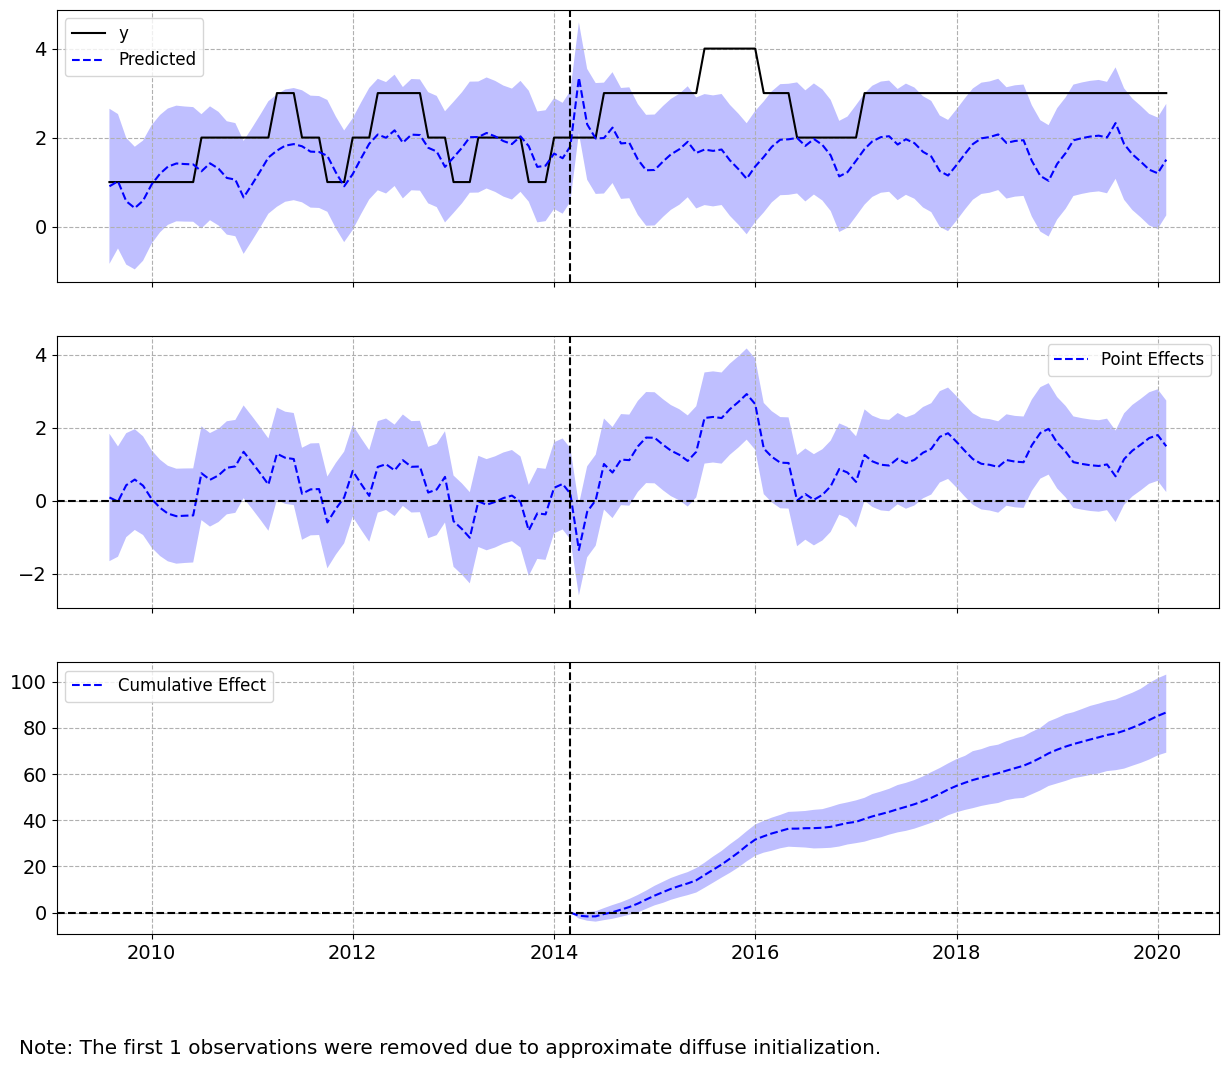

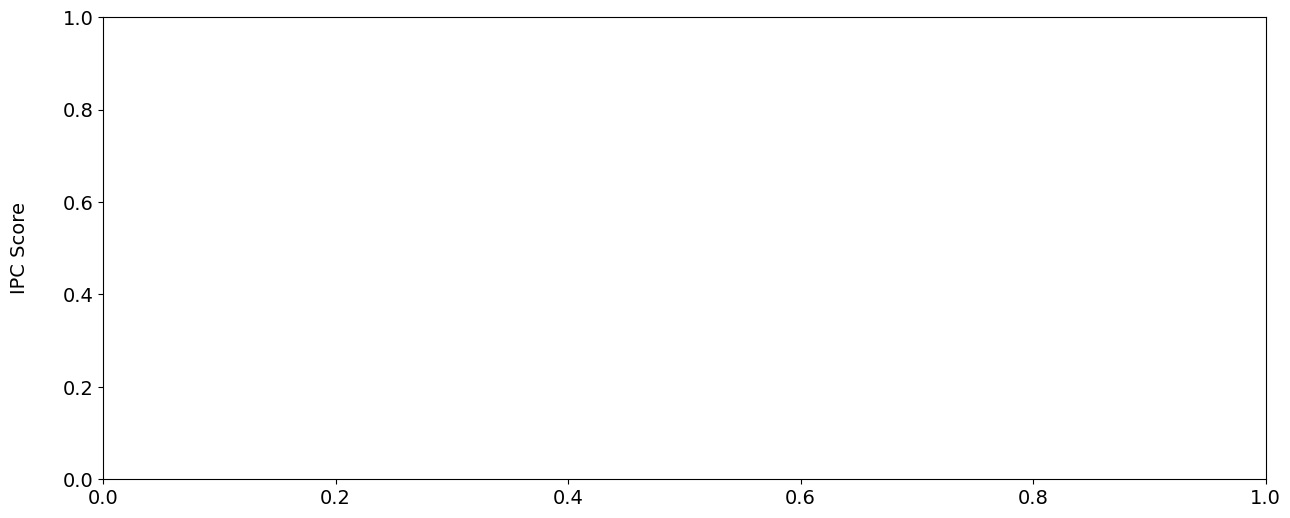

In [17]:

# Adjust font size and formatting globally
font = {
    'family': 'sans-serif',
    'weight': 'normal',
    'size': 12,
}

mpl.rc('font', **font)
mpl.rc('axes', titlesize=18)  # Title font size
mpl.rc('legend', fontsize=12)  # Legend font size
mpl.rc('xtick', labelsize=14)  # X-axis tick labels font size
mpl.rc('ytick', labelsize=14)  # Y-axis tick labels font size
mpl.rc('axes', labelsize=14)  # X and Y axis labels font size

impact.plot()

# Add a custom y-axis label
plt.text(-0.08, 0.5, 'IPC Score', rotation='vertical', va='center', fontsize=14, transform=plt.gca().transAxes)

# Show the plot
plt.show()

In [18]:
# Causal impact summary
print(impact.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    2.94               209.0
Prediction (s.d.)         1.72 (0.12)        122.35 (8.62)
95% CI                    [1.49, 1.97]       [105.96, 139.76]

Absolute effect (s.d.)    1.22 (0.12)        86.65 (8.62)
95% CI                    [0.98, 1.45]       [69.24, 103.04]

Relative effect (s.d.)    70.82% (7.05%)     70.82% (7.05%)
95% CI                    [56.59%, 84.22%]   [56.59%, 84.22%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


In [20]:
# Causal impact report
print(impact.summary(output='report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 2.94. By contrast, in the absence of an
intervention, we would have expected an average response of 1.72.
The 95% interval of this counterfactual prediction is [1.49, 1.97].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 1.22 with a 95% interval of
[0.98, 1.45]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 209.0.
By contrast, had the intervention not taken place, we would have expected
a sum of 122.35. The 95% interval of this prediction is [105.96, 139.76].


The above results are given in terms of absolute numbers. In relative
terms, the response variable showe